In [65]:
import numpy as np
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [76]:
# 1. Create Dummy Data
data = pd.DataFrame({
    'feature_A': [10, 12, 15, 11, 13, 30, 12, 14, 11, 12],
    'feature_B': [20, 22, 25, 21, 23, 5,  24, 26, 21, 22]
})
print("Original Data:\n", data)

Original Data:
    feature_A  feature_B
0         10         20
1         12         22
2         15         25
3         11         21
4         13         23
5         30          5
6         12         24
7         14         26
8         11         21
9         12         22


In [77]:
# 2. Scale the Data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled_data, columns=data.columns) # To keep column names
print("\nScaled Data:\n", scaled_df)

# 3. Initialize and Fit the LOF Model
lof = LocalOutlierFactor(n_neighbors=5, contamination='auto') # n_neighbors and contamination are hyperparameters
predictions = lof.fit_predict(scaled_data)


Scaled Data:
    feature_A  feature_B
0  -0.725476  -0.160894
1  -0.362738   0.196648
2   0.181369   0.732961
3  -0.544107   0.017877
4  -0.181369   0.375419
5   2.901905  -2.842460
6  -0.362738   0.554190
7   0.000000   0.911732
8  -0.544107   0.017877
9  -0.362738   0.196648


<Axes: xlabel='feature_A', ylabel='feature_B'>

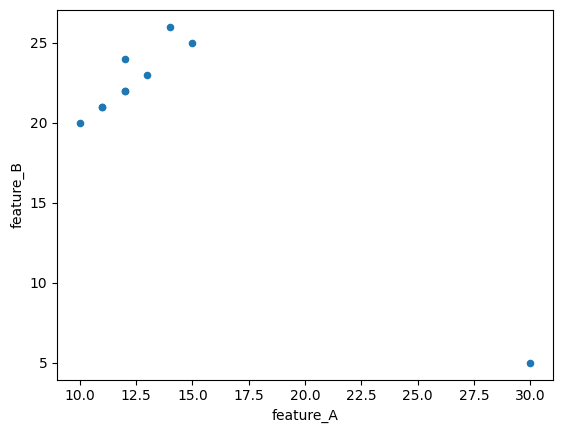

In [78]:
# Plotting points
data.plot(x='feature_A', y='feature_B',kind='scatter')

In [79]:
# 4. Analyze the Output
print("\nPredictions (1=inlier, -1=outlier):\n", predictions)

lof_scores = lof.negative_outlier_factor_ # Note: It's negative LOF
print("\nLOF Scores (Negative values, lower is more outlier-like):\n", lof_scores)


Predictions (1=inlier, -1=outlier):
 [ 1  1  1  1  1 -1  1  1  1  1]

LOF Scores (Negative values, lower is more outlier-like):
 [-1.149262   -0.99496812 -1.31154321 -1.00304495 -0.92098627 -9.16275904
 -1.00411144 -1.35056634 -1.00304495 -0.99496812]


In [80]:
outlier_df = data.copy()
outlier_df['LOF_Score'] = lof_scores
outlier_df['Outlier_Label'] = predictions
print("\nData with LOF Scores and Labels:\n", outlier_df)

# Identify and Print Outliers
outliers = outlier_df[outlier_df['Outlier_Label'] == -1]
print("\nIdentified Outliers:\n", outliers)


Data with LOF Scores and Labels:
    feature_A  feature_B  LOF_Score  Outlier_Label
0         10         20  -1.149262              1
1         12         22  -0.994968              1
2         15         25  -1.311543              1
3         11         21  -1.003045              1
4         13         23  -0.920986              1
5         30          5  -9.162759             -1
6         12         24  -1.004111              1
7         14         26  -1.350566              1
8         11         21  -1.003045              1
9         12         22  -0.994968              1

Identified Outliers:
    feature_A  feature_B  LOF_Score  Outlier_Label
5         30          5  -9.162759             -1


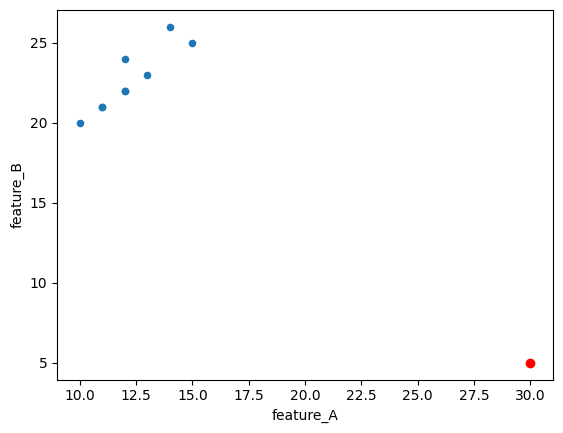

In [81]:
## plotting prediction
data.plot(x='feature_A', y='feature_B',kind='scatter')
plt.scatter(x=outliers.to_numpy()[0][0], y=outliers.to_numpy()[0][1], color='red')

In [50]:
# 5. Saving and Loading the Model (and Scaler) for Later Use

# --- Saving ---
import joblib # Or use 'pickle' library

# Save the LOF model
joblib.dump(lof, 'lof_model.joblib')

# Save the scaler as well (important for transforming new data later)
joblib.dump(scaler, 'scaler.joblib')
print("\nLOF model and scaler saved to disk.")

# --- Loading ---
# loaded_lof = joblib.load('lof_model.joblib')
# loaded_scaler = joblib.load('scaler.joblib')
# print("\nLOF model and scaler loaded from disk.")


LOF model and scaler saved to disk.


In [55]:
# ... (code from previous implementation example) ...

# Analyze feature values of outliers
inlier_indices = [0, 1, 2, 3, 4, 6, 7, 8, 9]
print("\nFeature analysis of outliers:")
for index, outlier_row in outliers.iterrows():
    print(f"\nOutlier at index {index}:")
    for feature in data.columns:
        outlier_value = outlier_row[feature]
        feature_mean_inliers = data[data.index.isin(inlier_indices)][feature].mean() #Indices of inliers could be tracked during prediction
        feature_std_inliers = data[data.index.isin(inlier_indices)][feature].std()
        z_score = (outlier_value - feature_mean_inliers) / feature_std_inliers if feature_std_inliers != 0 else 0 # Z-score: how many std deviations away from mean

        print(f"  - Feature '{feature}': Value = {outlier_value:.2f}, Mean (Inliers) = {feature_mean_inliers:.2f}, Z-score = {z_score:.2f}")


Feature analysis of outliers:

Outlier at index 5:
  - Feature 'feature_A': Value = 30.00, Mean (Inliers) = 12.22, Z-score = 11.37
  - Feature 'feature_B': Value = 5.00, Mean (Inliers) = 22.67, Z-score = -8.83


In [60]:
# ... (previous code setup) ...

n_neighbors_values = [3, 5, 7] # Values to test
contamination_values = ['auto', 0.05] # Values to test

print("\nHyperparameter Exploration Results:")
for n_neighbors_val in n_neighbors_values:
    for contamination_val in contamination_values:
        lof_tuned = LocalOutlierFactor(n_neighbors=n_neighbors_val, contamination=contamination_val)
        predictions_tuned = lof_tuned.fit_predict(scaled_data)
        lof_scores_tuned = lof_tuned.negative_outlier_factor_

        outlier_indices_tuned = np.where(predictions_tuned == -1)[0]
        num_outliers = len(outlier_indices_tuned)

        print(f"\n--- n_neighbors={n_neighbors_val}, contamination='{contamination_val}' ---")
        print(f"Number of outliers identified: {num_outliers}")
        print("Outlier indices:", outlier_indices_tuned)
        # You would add visual inspection or proxy metric calculation here for more systematic evaluation


Hyperparameter Exploration Results:

--- n_neighbors=3, contamination='auto' ---
Number of outliers identified: 3
Outlier indices: [2 5 7]

--- n_neighbors=3, contamination='0.05' ---
Number of outliers identified: 1
Outlier indices: [5]

--- n_neighbors=5, contamination='auto' ---
Number of outliers identified: 1
Outlier indices: [5]

--- n_neighbors=5, contamination='0.05' ---
Number of outliers identified: 1
Outlier indices: [5]

--- n_neighbors=7, contamination='auto' ---
Number of outliers identified: 1
Outlier indices: [5]

--- n_neighbors=7, contamination='0.05' ---
Number of outliers identified: 1
Outlier indices: [5]


In [72]:
lof_scores

array([-1.149262  , -0.99496812, -1.31154321, -1.00304495, -0.92098627,
       -9.16275904, -1.00411144, -1.35056634, -1.00304495, -0.99496812])

In [85]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report

# Assume 'ground_truth_labels' is a numpy array or list of 0s (inliers) and 1s (outliers)
# ... (run LOF and get lof_scores) ...

ground_truth_labels = [1,1,1,1,1,-1,1,1,1,1]

# ROC AUC
roc_auc = roc_auc_score(ground_truth_labels, -lof_scores) # Invert LOF scores for ROC curve direction
print(f"ROC AUC: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(ground_truth_labels, -lof_scores)
# ... (code to plot ROC curve if needed) ...

# Confusion Matrix (with a threshold on LOF score to classify as outlier)
threshold_score = -1.5 # Example threshold - needs to be chosen based on score distribution
predicted_labels_threshold = np.where(lof_scores < threshold_score, -1, 1) # 1 for outlier, 0 for inlier

conf_matrix = confusion_matrix(ground_truth_labels, predicted_labels_threshold)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report(ground_truth_labels, predicted_labels_threshold))

ROC AUC: 0.0000

Confusion Matrix:
 [[1 0]
 [0 9]]

Classification Report:
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         9

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

